# Lab 5 — Segmentación Médica con nnU-Net (v2)

En este laboratorio aplicaremos nnU-Net (v2), una arquitectura de segmentación médica *self-configuring*, en imágenes de CT abdominal.

El objetivo es segmentar las venas hepáticas a partir de un subconjunto de 5 volúmenes del dataset *Colorectal Liver Metastases (CLM)*.

**Objetivos:**
1. Comprender el flujo de trabajo de nnU-Net (preprocesamiento → inferencia → visualización).
2. Usar un modelo preentrenado para inferir venas hepáticas.
3. Evaluar y visualizar resultados en 3D y video.

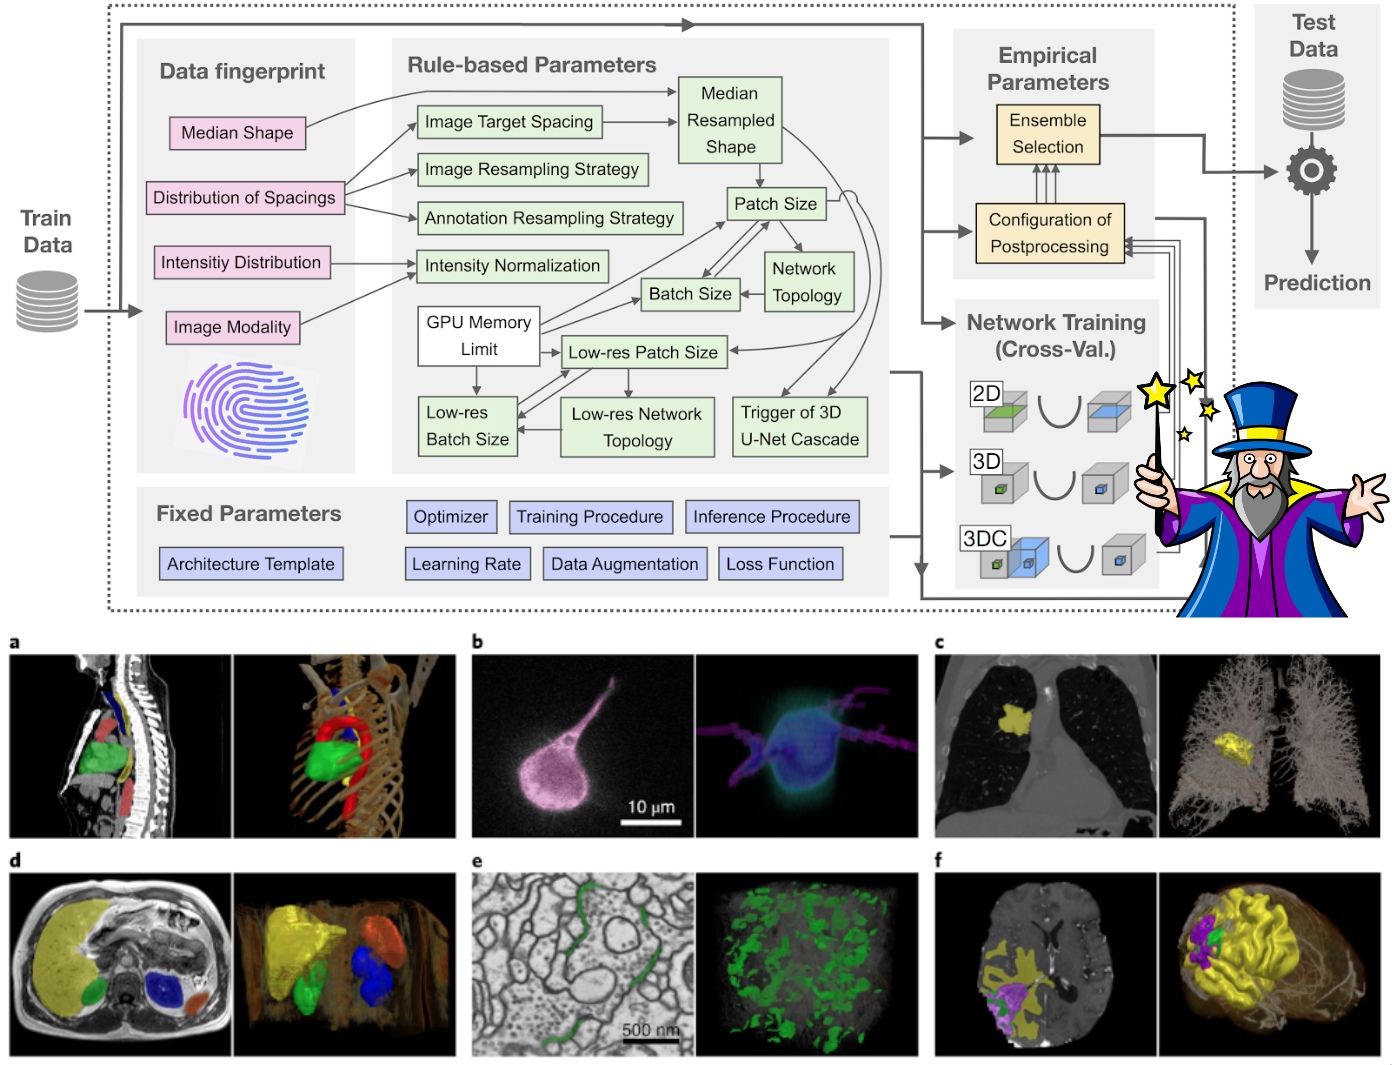

## Setup y dependencias

Instalamos `nnunetv2` del repositorio de github.

In [1]:
!git clone https://github.com/MIC-DKFZ/nnUNet.git
%cd /content/nnUNet
!pip install -q -e .

Cloning into 'nnUNet'...
remote: Enumerating objects: 14005, done.
remote: Total 14005 (delta 0), reused 0 (delta 0), pack-reused 14005 (from 1)
Receiving objects: 100% (14005/14005), 8.60 MiB | 25.99 MiB/s, done.
Resolving deltas: 100% (10703/10703), done.
/content/nnUNet
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [2]:
import os, json, shutil
from pathlib import Path
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import nibabel as nib
from skimage import measure
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import VBox
from IPython.display import display

## Variables de entorno y estructura de carpetas

nnU‑Net usa tres rutas:
- `NNUNET_RAW` (datasets crudos en formato nnUNet)
- `NNUNET_PREPROCESSED` (datos preprocesados)
- `NNUNET_RESULTS` (checkpoints, logs, predicciones)

Crearemos estas carpetas en `/content/nnunet_data`.

In [3]:
BASE = Path('/content/nnunet_data')
RAW = BASE / 'raw'
PRE = BASE / 'preprocessed'
RES = BASE / 'results'
for p in [RAW, PRE, RES]:
    p.mkdir(parents=True, exist_ok=True)
os.environ['nnUNet_raw'] = str(RAW)
os.environ['nnUNet_preprocessed'] = str(PRE)
os.environ['nnUNet_results'] = str(RES)
print('nnUNet_raw =', os.environ['nnUNet_raw'])
print('nnUNet_preprocessed =', os.environ['nnUNet_preprocessed'])
print('nnUNet_results =', os.environ['nnUNet_results'])

nnUNet_raw = /content/nnunet_data/raw
nnUNet_preprocessed = /content/nnunet_data/preprocessed
nnUNet_results = /content/nnunet_data/results


## Descarga de modelos y datos para inferir

Usaremos una parte del dataset [Colorectal-Liver-Metastases](https://www.cancerimagingarchive.net/collection/colorectal-liver-metastases/) que contiene imágenes 3D de tomografía computarizada (CT) de abdomen.

Cada corte o slice de un CT se ve algo así:

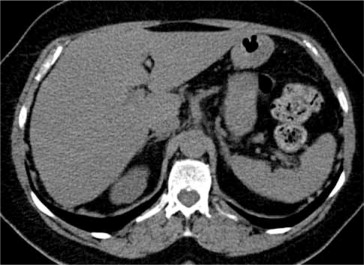

In [4]:
%cd /content
!wget "https://www.dropbox.com/scl/fi/pkhu8wcddyhulvk96cmcg/nnUNet_base.zip?rlkey=vspwlqk7sqq947yl9ss8of1yt&st=lseeu3vv&dl=0" -q -O nnUNet_base.zip
!wget "https://www.dropbox.com/scl/fi/wkhhkt8l3alza2128x89e/CRLM.zip?rlkey=8u22886he17w4tjiga6vfx76p&st=uh2nlel9&dl=0" -q -O CRLM.zip
!unzip CRLM.zip

/content
Archive:  CRLM.zip
   creating: CRLM/
   creating: CRLM/images/
  inflating: CRLM/images/1_0000.nii.gz  
  inflating: CRLM/images/2_0000.nii.gz  
  inflating: CRLM/images/3_0000.nii.gz  
  inflating: CRLM/images/4_0000.nii.gz  
  inflating: CRLM/images/5_0000.nii.gz  
   creating: CRLM/masks/
  inflating: CRLM/masks/1.nii.gz     
  inflating: CRLM/masks/2.nii.gz     
  inflating: CRLM/masks/3.nii.gz     
  inflating: CRLM/masks/4.nii.gz     
  inflating: CRLM/masks/5.nii.gz     


## Instalación del modelo preentrenado

In [5]:
!nnUNetv2_install_pretrained_model_from_zip "/content/nnUNet_base.zip"

## Predicción en 5 casos del dataset

In [6]:
!nnUNetv2_predict -i "/content/CRLM/images" -o "/content/preds" -d 1 -c 3d_custom -f 0 -chk checkpoint_best.pth -tr nnUNetTrainer


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 5 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 5 cases that I would like to predict

Predicting 1:
perform_everything_on_device: True
100% 12/12 [00:17<00:00,  1.44s/it]
sending off prediction to background worker for resampling and export
done with 1

Predicting 2:
perform_everything_on_device: True
100% 6/6 [00:06<00:00,  1.10s/it]
sending off prediction to background worker for resampling and export
done with 2

Predicting 3:
perform_everything_on_device: True
100% 8/8 [00:09<00:00,  1.15s/it]
sending off predi

## Evaluación rápida (Dice) y visualización

Calculamos IoU y Dice y mostramos cortes 2D con GT vs Pred.

$$\text{IoU}(A,B)=\frac{|A\cap B|}{|A\cup B|} \ \ \ \ \text{Dice}(A,B)=\frac{2|A\cap B|}{|A|+|B|}$$

In [7]:
def iou_and_dice(gt, pr, label=1):
    gt_bin = (gt == label).astype(np.uint8)
    pr_bin = (pr == label).astype(np.uint8)
    inter = (gt_bin & pr_bin).sum()
    union = (gt_bin | pr_bin).sum()
    denom = gt_bin.sum() + pr_bin.sum()
    iou = inter / union if union>0 else 1.0
    dice = (2.0 * inter / denom) if denom>0 else 1.0
    return iou, dice

def load_and_crop_ct(img_path, gt_path, seg_path):
    img = sitk.GetArrayFromImage(sitk.DICOMOrient(sitk.ReadImage(img_path), 'LPS'))
    gt = sitk.GetArrayFromImage(sitk.DICOMOrient(sitk.ReadImage(gt_path), 'LPS'))
    seg = sitk.GetArrayFromImage(sitk.DICOMOrient(sitk.ReadImage(seg_path), 'LPS'))

    z, y, x = np.where(img > 0)
    img = img[z.min():z.max()+1, y.min():y.max()+1, x.min():x.max()+1]
    gt = gt[z.min():z.max()+1, y.min():y.max()+1, x.min():x.max()+1]
    seg = seg[z.min():z.max()+1, y.min():y.max()+1, x.min():x.max()+1]

    img = np.clip(img, 0, 400)
    return img, gt, seg

# normaliza una imagen 2D a [0,1]
def norm01(img2d):
    img2d = img2d.astype(np.float32)
    lo, hi = np.percentile(img2d, 1), np.percentile(img2d, 99)
    denom = (hi - lo) if (hi - lo) > 1e-8 else 1.0
    x = (img2d - lo) / denom
    return np.clip(x, 0, 1)

# overlay binario (mask > 0) sobre una imagen 2D en escala
def overlay(gray2d, mask2d, color=(255, 0, 0), alpha=0.5):
    g = norm01(gray2d)
    base = np.stack([g, g, g], axis=-1)  # (H,W,3)
    m = (mask2d > 0).astype(np.float32)[..., None]
    col = (np.array(color, dtype=np.float32) / 255.0)[None, None, :]
    out = (1 - alpha * m) * base + (alpha * m) * col
    return np.clip(out, 0, 1)

def plot_results_slicer(
    img_id,
    img_root="/content/CRLM/images",
    gt_root="/content/CRLM/masks",
    pred_root="/content/preds",
    ALPHA=0.5
):
    # Cargar volúmenes (usa tu función para mantener orientación/recorte)
    img_path = f"{img_root}/{img_id}_0000.nii.gz"
    gt_path  = f"{gt_root}/{img_id}.nii.gz"
    pr_path  = f"{pred_root}/{img_id}.nii.gz"

    img, gt, pr = load_and_crop_ct(img_path, gt_path, pr_path)  # (Z,Y,X)

    # Métricas volumétricas
    iou, dice = iou_and_dice(gt, pr)

    # Slider de slice
    sld = widgets.IntSlider(value=img.shape[0] // 2, min=0, max=img.shape[0] - 1, step=1, description="Slice")

    out = widgets.Output()

    def _draw(idx):
        with out:
            out.clear_output(wait=True)
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            fig.suptitle(f"{img_id} | slice {idx} | IoU={iou:.4f} · Dice={dice:.4f}", y=1.02)

            # Panel 1: imagen original
            axes[0].imshow(norm01(img[idx]), cmap='gray', origin='lower')
            axes[0].set_title("Imagen")
            axes[0].axis('off')

            # Panel 2: GT overlay (verde)
            axes[1].imshow(overlay(img[idx], gt[idx], color=(0, 255, 0), alpha=ALPHA), origin='lower')
            axes[1].set_title("Ground Truth")
            axes[1].axis('off')

            # Panel 3: Pred overlay (rojo)
            axes[2].imshow(overlay(img[idx], pr[idx], color=(255, 0, 0), alpha=ALPHA), origin='lower')
            axes[2].set_title("Predicción")
            axes[2].axis('off')

            plt.tight_layout()
            plt.show()

    # callback
    def _on_change(change):
        if change["name"] == "value":
            _draw(change["new"])

    sld.observe(_on_change, names='value')
    _draw(sld.value)
    display(VBox([sld, out]))

In [8]:
plot_results_slicer(2) # img_id del 1 al 5

## Visualización 3D

In [115]:
def show_gt_pred_3d(img_id,
                    gt_root="/content/CRLM/masks",
                    pred_root="/content/preds",
                    color_gt='green',
                    color_pred='red',
                    opacity=0.35):
    """
    Visualiza GT y Pred simultáneamente con colores distintos.
    """
    gt_path  = f"{gt_root}/{img_id}.nii.gz"
    pred_path  = f"{pred_root}/{img_id}.nii.gz"
    gt = sitk.GetArrayFromImage(sitk.DICOMOrient(sitk.ReadImage(gt_path), "RAS"))
    pred = sitk.GetArrayFromImage(sitk.DICOMOrient(sitk.ReadImage(pred_path), "RAS"))
    gt = (gt>0).astype(np.float32)
    pred = (pred>0).astype(np.float32)

    spacings = [(1.5, 0.8, 0.8),
                (1.5, 0.85, 0.85),
                (5.0, 0.77, 0.77),
                (7.5, 0.70, 0.70),
                (1.5, 0.74, 0.74)]

    # Convierte una máscara binaria (Z,Y,X) en malla (vértices y caras)
    verts_g, faces_g, _, _ = measure.marching_cubes(gt, level=0.5, spacing=spacings[img_id-1], step_size=2)
    verts_p, faces_p, _, _ = measure.marching_cubes(pred, level=0.5, spacing=spacings[img_id-1], step_size=2)

    fig = go.Figure()
    if len(verts_g):
        kg, ig, jg = faces_g.T
        zg, xg, yg = verts_g.T
        fig.add_trace(go.Mesh3d(x=xg,y=yg,z=zg,i=ig,j=jg,k=kg,opacity=opacity,color=color_gt,name='GT'))
    if len(verts_p):
        kp, ip, jp = faces_p.T
        zp, xp, yp = verts_p.T
        fig.add_trace(go.Mesh3d(x=xp,y=yp,z=zp,i=ip,j=jp,k=kp,opacity=opacity,color=color_pred,name='Pred'))

    fig.update_layout(scene=dict(aspectmode='data'), title="GT (verde) vs Pred (rojo)", height=650)
    fig.show()

In [117]:
show_gt_pred_3d(1)